### María Sofía Álvarez - Brenda Barahona - Álvaro Plata
<h1 align='center'>Proyecto 1: Analítica de textos - Preprocesamiento</h1>

En esta fase del proyecto, nos encargaremos de construir las pipelines necesarias para desplegar nuestros modelos en una API. Para ello, únicamente nos remitiremos a construir los 3 modelos que nos dieron los mejores resultados en la fase 1 de este proyecto, después de realizar el ajuste de hiperparámetros desarrollado en la fase anterior. Este notebook se divide en ciertas fases. Primero, se realiza todo el preprocesamiento, que es común a todos los modelos. Segundo, se terminan de construir las pipelines propias de cada modelo, de acuerdo con los hiperparámetros que fueron ajustados en la fase 1 (solo con ellos, para ahorrar tiempo de cómputo). Por último, se exportan los tres modelos.

Si desea ver a fondo alguna parte del perfilamiento, preprocesamiento de datos realizado, o ajuste de hiperparámetrod, remítase al repositorio de github de la fase 1 de este proyecto, disponible en <a href="https://github.com/sofiaalvarezlopez/Proyecto-1-BI">este link</a>.

## Importación de librerías
Importamos las librerías necesarias para el desarrollo de este proyecto. Las librerías instaladas son exactamente las mismas que las que se instalaron para la fase 1 de este proyecto.

In [38]:
# ESAI
import re
import nltk
import keras
import spacy
import inflect
import sent2vec # Para descargar esta libreria, es necesario descargarla desde GitHub https://github.com/epfml/sent2vec
import stopwords
import numpy as np
import unicodedata
import pandas as pd
import contractions
import seaborn as sns
#nltk.download('wordnet')
#nltk.download('omw-1.4')
import pandas_profiling as pp
from joblib import dump, load
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from keras.callbacks import EarlyStopping
from sklearn.naive_bayes import ComplementNB
from nltk import word_tokenize, sent_tokenize
from tensorflow.keras.models import Sequential
from sklearn.utils import resample, class_weight
from keras.wrappers.scikit_learn import KerasClassifier
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.metrics import precision_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from clases import Preprocessing, StemAndLemmatize, VectorizeLSTM, LSTMBuilder
from keras.layers import LSTM, Dense, Embedding, TextVectorization, Input, Dropout
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, ConfusionMatrixDisplay

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [4]:
%matplotlib inline

Procedemos, entonces, a ver los datos suministrados. 

In [8]:
diagnoses =pd.read_csv('ApoyoDiagnosticoEstudiante/medical_text_clasificacion.csv')
X, Y = diagnoses.drop(['problems_described'], axis=1), diagnoses['problems_described']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,stratify=Y,test_size=0.01, random_state=28)
data_train = pd.concat( [X_train, Y_train], axis=1)

## Preprocesamiento
Iniciamos con la fase de preprocesamiento de los datos:
### Extracción de entidades médicas
De acuerdo con [4], para clasificación en contextos médicos es útil extraer entidades médicas para la clasificación, como se hizo en el proyecto pasado. No obstante, se obtuvieron mejores resultados con las entidades en todos los casos, así que se omitirá este pedazo:
```python
nlp = en_ner_bionlp13cg_md.load()
def medical_entities(text):
    entities = []
    doc = nlp(text)
    for ent in doc.ents:
        entities.append(ent.text)
    return ' '.join(entities)
```


### Manejo de Ruido 
En esta sección se quitará o modificará todo lo que se considere como ruido:

+ Caracteres no ascii: Hace parte importante del preprocesamiento de las palabras. Con caracteres no-ascii, el preprocesamiento puede verse terriblemente perjudicado.
+ Se pasará de mayusculas a minusculas: Asimismo, es importante que todas las palabras tengan una capitalización homogénea (en este caso, queremos que estén en minúscula).
+ Se eliminará la puntuación: Por otro lado, consideramos que la puntuación no provee información adicional en este contexto. Adicionalmente, de no eliminarse, puede aumentar la dimensionalidad de los datos sin proveer más información. Por ejemplo, no tiene sentido pensar que "almuerzo!" y "almuerzo" sean palabras diferentes. Por ello removemos toda la puntuación usando expresiones regulares.
+ Se reemplazarán los números: Ahora, podemos suponer que los números no proveen información relevante para el problema en cuestión. Estos pueden también agregar dimensionalidad inutilmente al problema.
+ Se quitarán las fechas (si las hay) también: las fechas son irrelevantes para el contexto del problema.
+ Se quitarán las palabras vacias (artículos, pronombres, preposiciones): Estas se denominan stop-words, en inglés. Son palabras que se usan en muchos contextos (como 'the') y no aportan información significativa en la construcción del modelo. Asimismo, definimos nuestras propias stopwords de acuerdo con el perfilamiento realizado, pues son palabras que no aportan significativamente al contexto.

```python
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words
    

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    p = inflect.engine()
    new_words = []
    for word in words:
        new_word = re.sub('\d+.*', '', word)
        if not word.isnumeric() and new_word != '':
            new_words.append(word)
    return new_words

def remove_dates(words):
    """Replace all dates in our data"""
    new_words = []
    for word in words:
        new_word = re.sub(r'\d+/\d+/\d+', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words
```


De todas estas palabras, encontramos que solamente tumor y lesion pueden ser relevantes para nuestro análisis. Por lo tanto, las quitamos todas, excepto estas dos. Además, en un análisis preliminar encontramos otras palabras irrelevantes, las cuales también eliminamos.

```python
#En una primera iteracion nos dimos cuenta que las palabras "paty", "patients" aparece frecuentemente en todas las enfermedades,
#estos serán eliminados por que no agregan información valiosa. 
our_stopwords = ["paty","patients","p","study","result", "human", "humans", "monkey", "monkeys", 
                 "diseases", "studied","first", "rat", "patient", "case", "p less", "treatment", 
                 "group", "associated", "result", "may", "effect", "compared", "use", "cases", "year", 
                 "years", "age", "study", "disease", "found", "normal", "month", "although", "per cent",
                 "one", "two", "three", "four", "n", "children", "women"]

def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords.words('english') and word not in our_stopwords:
            new_words.append(word)
    return new_words
```
Asimismo, tenemos la función de eliminación del ruido global:

``` python
def noise_elimination(words):
    words = to_lowercase(words)
    words = remove_non_ascii(words)
    words = remove_numbers(words)
    words = remove_dates(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words
```




Con esto, ya tenemos casi listo nuestro proceso de eliminación del ruido. Primero, llamamos a la función <code>fix</code> de la librería ```contraction``` para aquellas contracciones que no están separadas en dos palabras. Esta elimina todas las ocurrencias de contracciones en inglés, reemplazándolas por su equivalente sin contracción. Una vez realizado este paso, "tokenizamos" las historias clínicas. Para poder evaluar cada palabra por separado y aplicar los pasos de preprocesamiento, hacemos la tokenización en palabras individuales usando el módulo ```word_tokenize```. Finalmente, aplicamos la función```noise_elimination``` definida previamente.

Más adelante, lo que realmente nos servirá será volver a tener los documentos sin tokenización para el proceso de vectorización (sea tf-idf, o BioSentVec, como se vera mas adelante). Entonces, volvemos a juntar todas las palabras para cada documento y retornamos eso. También retornamos las palabras tokenizadas con el fin de realizar la lematización estemización más adelante.

Note que estas funciones las aplicamos tanto sobre los medical abstracts iniciales, como las palabras clave que obtuvimos con la librería de SpaCy descrita previamente.

```python
def preprocessing(X):
    new_X_train= X.apply(contractions.fix) #Aplica la corrección de las contracciones
    new_X_train = new_X_train.apply(word_tokenize)
    new_X_train = new_X_train.apply(noise_elimination) #Aplica la eliminación del ruido
    X_train = new_X_train.apply(lambda x: ' '.join(map(str, x)))
    return new_X_train, X_train
```

### Normalización: Stemming y Lemmatization 
Aplicaremos tecnicas como "Stemming" y "Lemmatization" sobre la columna "medical_abstracts". 

En esta parte del preprocesamiento, hacemos una eliminación de prefijos y sufijos, así como una lematización de los verbos. En el caso del Stemming hay varios algoritmos que podemos utilizar: Porter, Snowball (Porter2) o Lancaster (Paice-Husk). De acuerdo a lo que encontramos,  <a href="https://stackoverflow.com/questions/10554052/what-are-the-major-differences-and-benefits-of-porter-and-lancaster-stemming-alg"> la agresividad en el corte de raíces de las palabras de estos algoritmos aumenta, siendo Porter el menos agresivo y Lancaster el más agresivo </a>. En este sentido, parece ser que Lancaster (a pesar de ser el más eficiente de todos), puede ser poco riguroso y así crear muchas ambigüedades. Asimismo, Porter2 es un poco más agresivo que Porter, sin perder mucho el origen de las palabras y con un tiempo de cómputo razonable. El mismo Porter, creador del algoritmo, argumenta que es una mejora de su algoritmo original. Con el fin de tener la mejor preparación de las palabras, en un tiempo de cómputo razonable, decidimos usar Porter2. En el caso de la lematización, sí usamos WordNetLemmatizer() al ser el más usado en el mundo del procesamiento de textos.
```python
#Funciones de "Stemming" y "Lemmatization"
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def stem_and_lemmatize(words):
    stems = stem_words(words)
    lemmas = lemmatize_verbs(words)
    return stems + lemmas
```

Y creamos la clase correspondiente para las funciones:
``` python
class StemAndLemmatize():
    def __init__(self):
        pass
    def transform(self,X,y=None):
        X["medical_abstracts"] = X["medical_abstracts"].apply(stem_and_lemmatize)
        return X
    def fit(self, X, y=None):
        return self
```

Finalmente, con todas las funciones definidas, creamos el pipeline de preprocesamiento:

In [9]:
preproc = [
    ("preprocessing", Preprocessing()),
    ("stem_lemmatize", StemAndLemmatize())
]

In [10]:
pipe  = Pipeline(preproc)

Veamos una muestra de los textos preprocesados:

In [11]:
datos_train_procesados = pipe.fit_transform(data_train, data_train['problems_described'])
datos_train_procesados.head(5)

,medical_abstracts,problems_described
4888,"[threedimension, system, longterm, cultur, col...",1
3247,"[brainstem, auditori, evok, respons, acoust, n...",3
5261,"[methodolog, mental, stress, test, cardiovascu...",4
9568,"[applic, modifi, bioassay, monitor, serum, tei...",5
10074,"[fine, surfac, structur, intraspin, neurenter,...",5


Finalmente, almacenamos los datos de entrenamiento en un archivo <code>.csv</code> denominado: <code>proyecto1_fase2_datos_entrenamiento.csv</code>:

In [12]:
datos_train_procesados.to_csv("proyecto1_fase2_datos_preprocesados.csv")

## Modelo: LSTM
En la iteración pasada, diseñamos tres algoritmos de Machine Learning para probar: Naïve-Bayes, OneVsRest y una red neuronal usando una LSTM (Long-Short Term Memory). De estos, el que mejores métricas arrojó fue el LSTM. Por lo tanto, debido a que buscamos optimizar la precisión de nuestro modelo para el cliente, este es el que desplegaremos en la API. Si desea ver más información acerca de la LSTM, remítase al repositorio del proyecto anterior.

La LSTM (Long-Short Term Memory) es un tipo de red neuronal recurrente (RNN, por sus siglas en inglés) que se desempeña mejor que las RNN tradicionales en términos de memoria [1]. Una RNN es un tipo de red neuronal que permite a las salidas de capas previas ser utilizadas como entradas, teniendo estados ocultos [2].

Las LSTM tienen múltiples capas ocultas. A medida que se pasa a través de una capa, la información relevante se mantiene y la irrelevante se desecha en cada neurona (celda) individual [1]. Asimismo, las LSTM solucionan el problema de desvanecimiento de gradientes que las RNN enfrentan a menudo.

Las LSTM cuentan principalmente con 3 compuertas:
+ **FORGET Gate:** Esta compuerta es la responsable de decidir qué información se queda y cuál es irrelevante y debe descartarse. Para ello, utiliza la información que viene de la neurona anterior $h_{t-1}$ y la información de la celda actual, $x_t$. Sobre ellas, se corre una función sigmoide, $$S(x) = \frac{1}{1 + e^{-x}},$$ tal que los datos que tiendan a 0 son descartados por la red [1].
+ **INPUT Gate:** Esta compuerta actualiza el estado de la neurona y decide qué información es importante. Como la compuerta FORGET ayuda a descartar la información, la compuerta INPUT ayuda a encontrar la información importante y a almacenar ciertos datos relevantes en memoria. En este caso, la información de la neurona anterior, $h_{t-1}$ es pasada por una función de activación sigmoide, mientras que la información de la neurona actual $x_t$ se pasa por una función de activación de tangete hiperbólica: $$\tanh(x) = \frac{1 - e^{-2x}}{1 + e^{-2x}}.$$ Es importante resaltar que la función $\tanh$ ayuda a regular la red y a reducir el sesgo de la misma [1].
+ **OUTPUT Gate:** Tras multiplicar el estado actual de la neurona con lo que se obtiene de la compuerta FORGET, lo cual permite eliminar cierta información si la compuerta FORGET arroja pesos de 0, debe decidirse cual será el estado de la siguiente celda. La información de $h_{t-1}$ y $x_t$ se pasa a través de una función sigmoide, el cual es a su vez pasado por una función de tangente hiperbólica, y ambos resultados se mltiplican para decidir la información que llevará el estado oculto [1]. 

A continuación, puede verse la gráfica de las funciones $\tanh$ y sigmoide:

<img src="https://www.researchgate.net/profile/Muhammad-Hamdan-8/publication/327435257/figure/fig4/AS:742898131812354@1554132125449/Activation-Functions-ReLU-Tanh-Sigmoid.ppm" />

Note que también se encuentra la función de activación ReLU (Regularized Linear Unit), muy popular en las aplicaciones de Machine y Deep Learning.

Asimismo, puede verse una representación esquemática (obtenida de [3]) de la estructura de cada una de las compuertas:

<img src="https://www.researchgate.net/profile/Xuan_Hien_Le2/publication/334268507/figure/fig8/AS:788364231987201@1564972088814/The-structure-of-the-Long-Short-Term-Memory-LSTM-neural-network-Reproduced-from-Yan.png" width=50% />

En la imagen podemos ver las funciones de activación usadas en cada celda LSTM (sigmoide y tangente hiperbólica), así como sus entradas, salidas y compuertas.

Finalmente, procedemos a volver a leer los datos para realizar el preprocesamiento desde 0.

In [26]:
diagnoses =pd.read_csv('ApoyoDiagnosticoEstudiante/medical_text_clasificacion.csv')
X, Y = diagnoses.drop(['problems_described'], axis=1), diagnoses['problems_described']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,stratify=Y,test_size=0.01, random_state=28)
data_train = pd.concat( [X_train, Y_train], axis=1)

### Manejo de desbalanceo de las clases

Ahora, uno de los mayores problemas de la clasificación es el contexto desbalanceado. Una opción sería reducir el conjunto de datos hasta que todas las clases queden con un número de abstracts igual al tamaño de la clase de menor cantidad de abstracts. No obstante, por lo general la idea es no reducir el conjunto de datos. Otra opción, como en los algoritmos anteriores, sería usar SMOTE. No obstante, esto es computacionalmente muy costoso para la red.

Lo que sí podemos hacer es considerar pesos. Así, el modelo podrá prestar mayor atención a las clases minoritarias. Para ello, usaremos la librería de <code>sk-learn</code> y lo pasaremos como un objeto al modelo que construiremos más adelante:

In [27]:
class_weights = class_weight.compute_class_weight(
                class_weight = 'balanced',
                classes = np.unique(Y_train), 
                y = Y_train)
train_class_weights_ = dict(enumerate(class_weights, start=1))
train_class_weights = dict(enumerate(class_weights))

Podemos ver los pesos asociados a cada una de las clases, en orden ascendente:

In [28]:
train_class_weights_

{1: 0.9127929312331925,
 2: 1.9332790886899918,
 3: 1.5,
 4: 0.946236559139785,
 5: 0.6010624841892234}

### Modelo

Usando el modelo de vectorización de BioSentVec, se obtuvo, utilizando la búsqueda de hiperparámetros, que el mejor modelo era aquel que no tenía ninguna capa adicional a las consideradas inicialmente (dos capas LSTM con sus respectivas capas de dropout), un dropout de 0.1 (i.e. una tasa de pérdida bastante pequeña) y cada una de las capas con 64 neuronas.

Finalmente, se tiene una capa softmax con 5 neuronas, que corresponden con las 5 clases del problema. Es importante mencionar que la variable categórica Y se debe convertir a la funcionalidad de Keras para el correcto funcionamiento de la red.

In [29]:
X, Y = data_train.drop(['problems_described'], axis=1), data_train['problems_described']
Y = keras.utils.np_utils.to_categorical(Y)[:,1:]

Y, por último, creamos la vectorización:

In [30]:
pipe.steps.append(('vectorizer', VectorizeLSTM()))

Veamos qué tiene la pipeline hasta ahora:

In [35]:
pipe

Pipeline(steps=[('preprocessing',
                 <clases.Preprocessing object at 0x7fde44fc8940>),
                ('stem_lemmatize',
                 <clases.StemAndLemmatize object at 0x7fde44fc88e0>),
                ('vectorizer',
                 <clases.VectorizeLSTM object at 0x7fde19467400>)])

Finalmente, creamos un clasificador de Keras usando el modelo de la red, de acuerdo con los hiperparámetros encontrados en el anterior proyecto:
```python
class LSTMBuilder():
    def __call__(self):
        output=5
        model = Sequential(name="LSTM")
        # Agregamos una capa LSTM con el tamanio de entrada de los embedded abstracts y 64 neuronas en la capa
        model.add(LSTM(units=64, return_sequences=True, 
                    input_shape=(1, 700)))
        model.add(Dropout(0.1))
        # Agregamos una segunda capa LSTM con 16 neuronas
        model.add(LSTM(units=64, return_sequences=False))
        # Con su respectiva capa de dropout
        model.add(Dropout(0.1))
        # Definimos la capa de salida
        model.add(Dense(output, activation='softmax'))
        # Compilo
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[keras.metrics.Precision(name='precision')])
        return model
```

In [36]:
clf = KerasClassifier(LSTMBuilder(), verbose=1)

In [37]:
pipe.steps.append((('model', clf)))

In [40]:
pipe_elegida = pipe.fit(X, Y, 
                        model__class_weight=train_class_weights,
                        model__callbacks=EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto', baseline=None),
                        model__validation_split=0.01, 
                        model__epochs= 50)

Model successfuly loaded
Epoch 1/50
368/368 [==============================] - 9s 5ms/step - loss: 1.0151 - precision: 0.6461 - val_loss: 0.8863 - val_precision: 0.7128
Epoch 2/50
368/368 [==============================] - 1s 4ms/step - loss: 0.8135 - precision: 0.6559 - val_loss: 0.8222 - val_precision: 0.7576
Epoch 3/50
368/368 [==============================] - 1s 3ms/step - loss: 0.7740 - precision: 0.6597 - val_loss: 0.7895 - val_precision: 0.7404
Epoch 4/50
368/368 [==============================] - 1s 3ms/step - loss: 0.7494 - precision: 0.6686 - val_loss: 0.8041 - val_precision: 0.7048
Epoch 5/50
368/368 [==============================] - 1s 3ms/step - loss: 0.7305 - precision: 0.6675 - val_loss: 0.7951 - val_precision: 0.7333
Epoch 6/50
368/368 [==============================] - 1s 4ms/step - loss: 0.7134 - precision: 0.6755 - val_loss: 0.7938 - val_precision: 0.7255
Epoch 7/50
368/368 [==============================] - 1s 3ms/step - loss: 0.7042 - precision: 0.6733 - val_loss

### Prueba de la calidad del modelo
Veamos la matriz de confusión y otras métricas pertinentes para este modelo. Para un análisis más exhaustivo, remítase al anterior proyecto.

In [58]:
y_pred = pipe_elegida.predict(X) + 1 # Sumamos 1 para que las clases nos queden entre 1 y 5 
Y_tr = Y.argmax(1) + 1 # Sumamos 1 para que las clases nos queden entre 1 y 5 

print('---Reporte para el modelo construido---')
print(classification_report(Y_tr, y_pred))

---Reporte para el modelo construido---
              precision    recall  f1-score   support

           1       0.75      0.87      0.80      2603
           2       0.53      0.91      0.67      1229
           3       0.56      0.86      0.67      1584
           4       0.72      0.81      0.76      2511
           5       0.84      0.31      0.45      3953

    accuracy                           0.67     11880
   macro avg       0.68      0.75      0.67     11880
weighted avg       0.72      0.67      0.65     11880



Podemos ver que, en promedio, la precisión de este modelo no es mala. De hecho, para tres de las 5 clases (neoplasias, enfermedades cardiovasculares y patologías generales, se tiene una precisión mayor o igual al 70%. Esperamos poder mejorar esto de alguna forma, para ello, intentamos otras técnicas.

Veamos ahora la matriz de confusión:

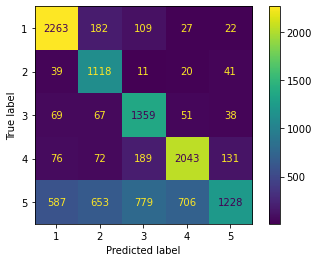

In [59]:
cm = confusion_matrix(Y_tr, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels= np.arange(1,6))
disp.plot()
plt.show()

En este caso, podemos ver que la clase que más se confunde es la 5: esto tiene sentido, pues las palabras que la conforman pueden caber en varias de las otras categorías. De resto, el modelo clasifica bien (sin mucho error) las otras clases. Note que las clases peor clasificadas son las minoritarias, incluso a pesar de que consideramos los pesos en la construcción del modelo.

### Obtención de las estadísticas
Veamos la probabilidad de que un texto determinado pertenezca a cada clase:

In [60]:
pred = pipe_elegida.predict_proba(X)

Model successfuly loaded


Veamos si las probabilidades coinciden con lo que la etiqueta, para el primer dato:

In [68]:
predicha_0 = np.argmax(pred[0])+1
real_0 = Y_tr[0]
print('La clase predicha es: {} con una probabilidad de {}%'.format(predicha_0, np.max(pred[0])*100) )
print('La clase real es {}'.format(real_0))

La clase predicha es: 1 con una probabilidad de 83.55962038040161%
La clase real es 1


Vemos que, para este dato en particular, la clase predicha y la real es la misma. Asimismo, la clase predicha tiene una buena probabilidad. El conocimiento de las probabilidades puede ser útil en el dominio médico porque permite al médico tener un segundo concepto, con una probabilidad menor, en caso de que el primero no lo satisfaga del todo. Es particularmente útil en el caso de las enfermedades tipo 5 (patologías generales), qu pueden confundirse como otro tipo de enfermedades.

### Exportación del modelo
Una vez entrenado el modelo, procedemos a guardarlo y exportarlo. Debido a que no existe una manera directa de almacenar un modelo de keras dentro de una pipeline de scikit learn, es necesario guardarlos por separado. Así, guardamos primero el modelo de Keras:

In [69]:
pipe_elegida.named_steps['model'].model.save('./assets/keras_model.h5')
pipe_elegida.named_steps['model'].model = None
dump(pipe_elegida, './assets/modelo.pkl')

['./assets/modelo.pkl']

<h2 id='bibliografia'>Bibliografía</h2>

---

<a id='geron'>[1]</a> Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow : concepts, tools, and techniques to build intelligent systems. Sebastopol, CA: O'Reilly Media. ISBN: 978-1491962299

<a id='nlp_profiler'>[2]</a> https://towardsdatascience.com/nlp-profiler-profiling-datasets-with-one-or-more-text-columns-9b791193db89

[3] https://www.kaggle.com/code/neomatrix369/nlp-profiler-simple-dataset/notebook

[4] Clinical Text Classification: https://www.kaggle.com/ritheshsreenivasan/clinical-text-classification

[5] https://www.analyticsvidhya.com/blog/2021/06/lstm-for-text-classification/

[6] https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-recurrent-neural-networks

[7] Application of Long Short-Term Memory (LSTM) Neural Network for Flood Forecasting - Scientific Figure on ResearchGate. Available from: https://www.researchgate.net/figure/The-structure-of-the-Long-Short-Term-Memory-LSTM-neural-network-Reproduced-from-Yan_fig8_334268507 [accessed 28 Mar, 2022]

[8] Zhang Y, Chen Q, Yang Z, Lin H, Lu Z. BioWordVec, improving biomedical word embeddings with subword information and MeSH. Scientific Data. 2019.

[9] https://towardsdatascience.com/simplified-math-behind-dropout-in-deep-learning-6d50f3f47275

[10] https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/

[11] https://towardsdatascience.com/7-tips-to-choose-the-best-optimizer-47bb9c1219e